In [1]:
import pandas as pd
from plotnine import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [2]:
import os
os.system('kaggle datasets download -d uciml/pima-indians-diabetes-database -f diabetes.csv');

In [3]:
dataset_df = pd.read_csv('diabetes.csv')
dataset_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Why outliers?

C:\Users\leoni\AppData\Roaming\Python\Python36\site-packages\plotnine\stats\smoothers.py:146: UserWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  warnings.warn("Confidence intervals are not yet implemented"


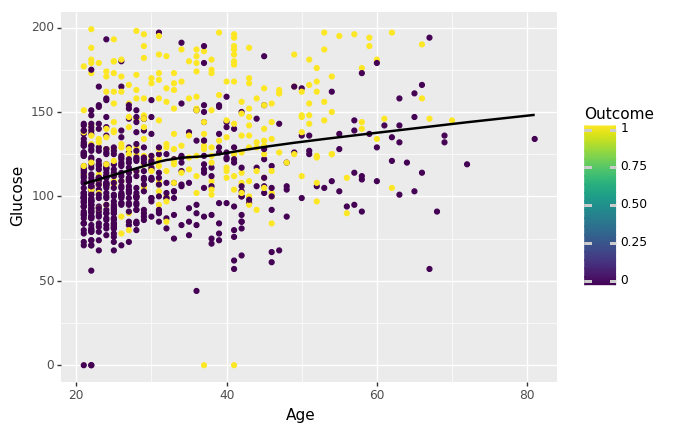

<ggplot: (-9223371894896722260)>

In [4]:
ggplot(dataset_df, aes(x='Age',y='Glucose',colour='Outcome'))